# Assignment: SVD Preprocessing on MNIST with Logistic Regression

## Instructions:
In this assignment, you will apply **Singular Value Decomposition (SVD)** as a preprocessing step to the **MNIST dataset** and train a **logistic regression classifier**. You will compare the model performance and training time when using different levels of SVD for dimensionality reduction.

In this assignment, you will need to:
1. Load the MNIST dataset and normalize it.
2. Perform SVD and reduce the dimensions of the data.
3. Train a logistic regression model on the original and SVD-reduced data.
4. Measure and compare the training time and accuracy of the model with varying SVD components.
5. Plot the results and analyze how SVD impacts the performance and efficiency of the model.

***
Your tasks include:
1. Implement SVD algorithm. You are not allowed to directly use SVD implemented by other packages, but you may use functions in NumPy. (Part 2)
2. Explore the accuracy and time performance from different numbers of SVD components. (Part 4)
3. Visualize the accuracy, time performance and top 5 singular vectors in the dataset, analyze and explain which number of SVD component looks best to you? (Part 4,5&6) Hint: singular vectors should be reshaped to 28x28 images for visualization.
***
**Note that you may not import any other function or package.** Let's get started!


## Part 1: Load the MNIST dataset and preprocess the data

In [2]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import time
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.datasets import fetch_openml # type: ignore
from sklearn.metrics import accuracy_score, classification_report # type: ignore

# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser = 'auto')
X = mnist.data
y = mnist.target

# Normalize the data
X = X / 255.0

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Loading MNIST dataset...


## Part 2: Implement SVD for Dimensionality Reduction

In [49]:
#This code was created with the help of ChatGPT to be more efficient, I am confident in my understanding of the material
import pandas as pd # type: ignore

def normalize(v):
    return v / np.linalg.norm(v)

def power_iteration(A, num_simulations=100):
    b_k = np.random.rand(A.shape[1])
    for _ in range(num_simulations):
        b_k1 = np.dot(A, b_k)
        
        b_k = normalize(b_k1)
    eigenvalue = np.dot(b_k.T, np.dot(A, b_k))
    return eigenvalue, b_k

def eigendecomposition(A, num_simulations=100):
    n = A.shape[0]
    eigenvalues = []
    eigenvectors = []
    
    A_copy = np.copy(A)
    
    for i in range(n):
        eigenvalue, eigenvector = power_iteration(A_copy, num_simulations)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)
        A_copy = A_copy - eigenvalue * np.outer(eigenvector, eigenvector)
    return np.array(eigenvalues), np.array(eigenvectors).T

def svd_truncated(A, n_components):
    # Step 1: Calculate A^T A
    AtA = np.dot(A.T, A)
    
    # Step 2: Eigen decomposition of A^T A to get V
    eigenvalues, V = np.linalg.eigh(AtA)
    
    # Step 3: Sort the eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices][:n_components]
    V = V[:, sorted_indices][:, :n_components]

    # Step 4: Calculate singular values (sigma)
    singular_values = np.sqrt(eigenvalues)
    
    # Step 5: Calculate U using the relationship A = U * Sigma * V^T
    U = np.dot(A, V) / singular_values
    
    return U, singular_values, V.T

def apply_svd_custom(X_train, X_test, n_components):
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
        
    # Reshape and flatten images (assuming each image is a 28x28 matrix)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Apply randomized SVD to both matrices
    U_train, Sigma_train, V_train = svd_truncated(X_train_flat, n_components)
    U_test, Sigma_test, V_test = svd_truncated(X_test_flat, n_components)
    
    # Return the SVD results for both train and test sets
    X_train_svd = U_train[:, :n_components] @ np.diag(Sigma_train[:n_components])
    X_test_svd = U_test[:, :n_components] @ np.diag(Sigma_test[:n_components])
    
    return X_train_svd, X_test_svd, V_train, V_test



## Part 3: Train Logistic Regression and Measure Performance

In [25]:
# Function to train logistic regression and track training time
def train_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='saga', random_state=42, multi_class='multinomial')
    
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy, training_time


## Part 4: Experiment with Different Levels of SVD

Now, apply SVD with varying numbers of components and observe how the dimensionality reduction impacts the model's performance. Record both the accuracy and training time for each number of components.


In [52]:
svd_components = [i for i in range(1,21)]  # You need to decide what number to search...
results = []
v_t = []

if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Training models with different levels of SVD preprocessing...")
for n_components in svd_components:
    print(f"Training on component: {n_components}")
    # Apply SVD to the training and test sets
    X_train_svd, X_test_svd, V_train_svd, V_test_svd = apply_svd_custom(X_train=X_train_flat, X_test=X_test_flat, n_components=n_components)

    # Train the logistic regression model and get accuracy and training time
    accuracy, training_time = train_logistic_regression(X_train_svd, y_train, X_test_svd, y_test)
    results.append((n_components, accuracy, training_time))
    v_t.append((V_train_svd, V_test_svd))

results_array = np.array(results)
max_accuracy_idx = np.argmax(results_array[:, 1]) 
max_accuracy = results_array[max_accuracy_idx, 1]
best_n_components = results_array[max_accuracy_idx, 0]
best_v_train, best_v_test = v_t[max_accuracy_idx]
print(f"\nMaximum accuracy: {max_accuracy:.4f} with {int(best_n_components)} components")

Training models with different levels of SVD preprocessing...
Training on component: 1
Training on component: 2
Training on component: 3
Training on component: 4
Training on component: 5
Training on component: 6
Training on component: 7
Training on component: 8
Training on component: 9
Training on component: 10
Training on component: 11
Training on component: 12
Training on component: 13
Training on component: 14
Training on component: 15
Training on component: 16
Training on component: 17
Training on component: 18
Training on component: 19
Training on component: 20

Maximum accuracy: 0.7246 with 6 components


## Part 5: Visualize and Analyze the Results

Finally, plot the accuracy, training time as a function of the number of SVD components, and top 5 singular vectors. This will help you understand the trade-off between dimensionality reduction, accuracy, and model training time, and how SVD generally works. Hint: singular vectors should be reshaped to 28x28 images for visualization.


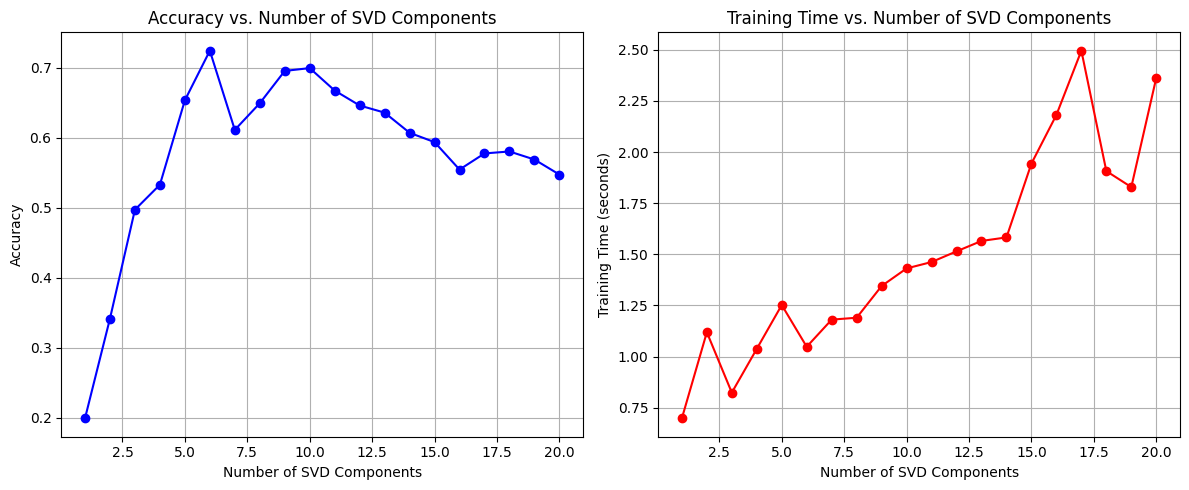

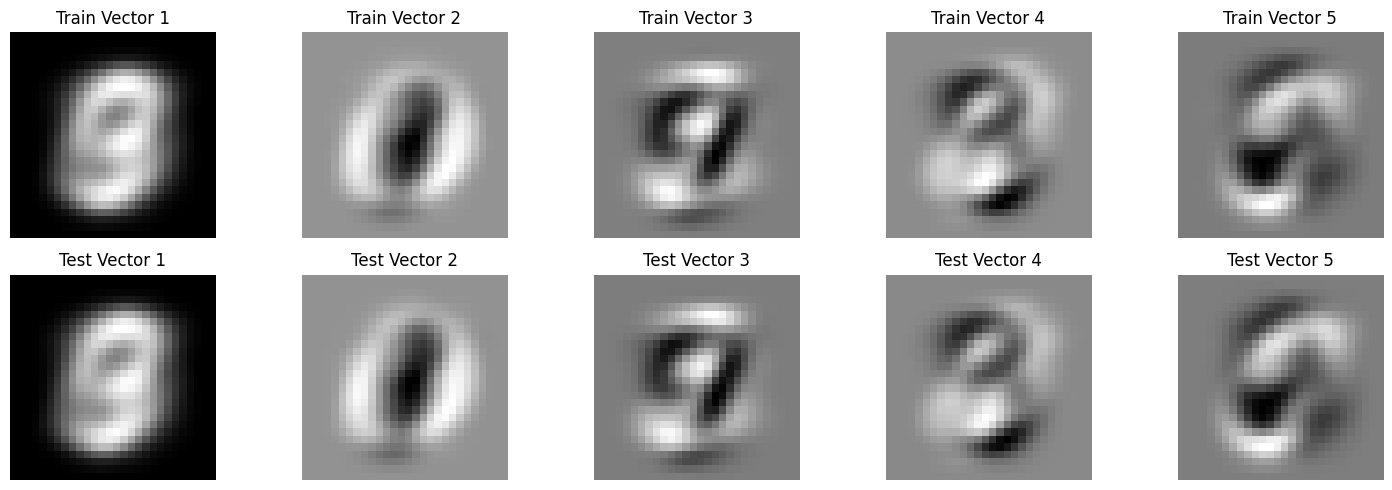

In [54]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore

# Function to plot the accuracy and training time
def plot_accuracy_and_training_time(svd_components, results_array):
    # Plot Accuracy vs. SVD components
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(svd_components, results_array[:, 1], marker='o', color='b')
    plt.title('Accuracy vs. Number of SVD Components')
    plt.xlabel('Number of SVD Components')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Plot Training Time vs. SVD components
    plt.subplot(1, 2, 2)
    plt.plot(svd_components, results_array[:, 2], marker='o', color='r')
    plt.title('Training Time vs. Number of SVD Components')
    plt.xlabel('Number of SVD Components')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to visualize the top 5 singular vectors as images

# Function to visualize the top 5 singular vectors as images
def plot_singular_vectors(Vt_train, Vt_test, num_vectors=5):
    plt.figure(figsize=(15, 5))
    
    # Plotting the singular vectors for the training set
    for i in range(num_vectors):
        plt.subplot(2, num_vectors, i + 1)
        singular_vector_train = Vt_train[i].reshape(28, 28)  # Reshape to 28x28
        plt.imshow(singular_vector_train, cmap='gray')
        plt.title(f"Train Vector {i + 1}")
        plt.axis('off')

    # Plotting the singular vectors for the testing set
    for i in range(num_vectors):
        plt.subplot(2, num_vectors, i + 1 + num_vectors)
        singular_vector_test = Vt_test[i].reshape(28, 28)  # Reshape to 28x28
        plt.imshow(singular_vector_test, cmap='gray')
        plt.title(f"Test Vector {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming svd_components and results_array are populated

# Example usage to plot accuracy and training time
plot_accuracy_and_training_time(svd_components, results_array)
plot_singular_vectors(best_v_train, best_v_test)

## Part 6: Analyze / Conclusion 

YOUR ANSWER: If you look at my graphs for accuracy vs. Number of SVD components, you might be confused why accuracy maxes out at 6 components and then seems to go down. This is because past the point of 6 components the information gained starts to peter out (We have reached the crook of the elbow). This means the logistic regression model is being trained on the training data in more dimensions, but this increase in dimensions only makes the model oversensitive to the quirks of the training data and therefore less accurate on the test data. This explains the sharp increase in accuracy before a downward trend after 6 (a common sign of overtraining). Next the strange bumps in the training time vs. number of svd components graph might also be confusing, but this again is a reflection of what amount of information about the dataset is being presented to the model. When the model is being trained with less information is tends to train quicker, but it also is dependent on how quickly the model can recognize trends in the data when most of the information is removed. Therefore when increasing the dimensions dramatically increases the data available to the model, it takes less time to train compared to lower dimensions because it recognizes patterns faster.